<a href="https://colab.research.google.com/github/sohumgautam17/nexus_ai_coursework/blob/main/Convolutional_Nerual_Network_Master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import torch
from torch import nn # This imports the neural network library (All the features we need are here)

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Subset, Dataset

from torchsummary import summary
from tqdm import tqdm

import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np

print(torch.__version__)

2.4.1+cu121


#Loading the CIFAR-10 Dataset from PyTorch torchvision (Step 1)
The first step of the project is to load the data we want to use.
CIFAR-10 is a widely-used dataset for image classification tasks, created by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. Here are its key characteristics:

1. The dataset consists of `60,000` color images of everyday objects:

>>50,000 training images
>>10,000 test images

2. Each image is '32x32` pixels with 3 color channels (RGB), making it slightly larger and more complex than Fashion-MNIST.

3. The dataset contains 10 different classes of objects, labeled from 0 to 9:

  1. Airplane
  2. Automobile
  3. Bird
  4. Cat
  5. Deer
  6. Dog
  7. Frog
  8. Horse
  9. Ship
  10. Truck

4. The classes are balanced, with each having exactly 5,000 training images and 1,000 test images.



![An Image](https://datasets.activeloop.ai/wp-content/uploads/2022/09/CIFAR-10-dataset-Activeloop-Platform-visualization-image-1.webp)

In [ ]:
train_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
    )

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [12]:
print(f'Length of the train dataset: {len(train_data)} | Shape of train data {train_data.data.shape}')
print(f'Length of the train dataset: {len(test_data)} | Shape of train data {test_data.data.shape}')

Length of the train dataset: 50000 | Shape of train data (50000, 32, 32, 3)
Length of the train dataset: 10000 | Shape of train data (10000, 32, 32, 3)


In [13]:
print(f'There are {len(train_data.classes)} classes (clothing items) in the dataset')
print(f'These are the classes: {train_data.classes}')

There are 10 classes (clothing items) in the dataset
These are the classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [14]:
print(f'Shape of the first image: {train_data[0][0].shape}') # The first zero indexes the tuple, the next indexes the image in the tuple
print(f'The class of the first image: {train_data[0][1]}')

Shape of the first image: torch.Size([3, 32, 32])
The class of the first image: 6


#Visualize

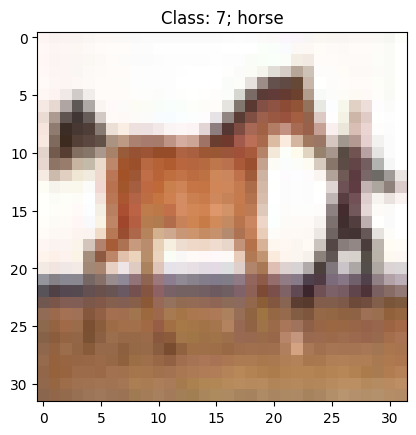

In [16]:
image_num = 9224 #@param {type:"raw"}
image = train_data[image_num][0].permute(1, 2, 0) # train_data[image_num] is a tuple of (image, label)... we index 0 to get the image
# Once we index 0, we change the order from (channel x height x width) -> (height, width, channel)***This is how matplotlib reads images
plt.imshow(image)
label = train_data[image_num][1]
plt.title(f'Class: {label}; {train_data.classes[label]}')
plt.show()

# Building the Model (Step 3)


In [17]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_layers = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.fully_connected = nn.Sequential(
        nn.Linear(in_features=32*8*8, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=10)
    )
    self.flatten = nn.Flatten()
  def forward(self, x):
    x = self.conv_layers(x)
    #print(f'Shape coming out of convnet will be: {x.shape}')
    x = self.flatten(x)
    x = self.fully_connected(x)
    return x

model = ConvNet()

In [18]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
         MaxPool2d-4           [-1, 16, 16, 16]               0
            Conv2d-5           [-1, 32, 16, 16]           4,640
       BatchNorm2d-6           [-1, 32, 16, 16]              64
              ReLU-7           [-1, 32, 16, 16]               0
         MaxPool2d-8             [-1, 32, 8, 8]               0
           Flatten-9                 [-1, 2048]               0
           Linear-10                  [-1, 128]         262,272
             ReLU-11                  [-1, 128]               0
           Linear-12                   [-1, 10]           1,290
Total params: 268,746
Trainable params: 268,746
Non-trainable params: 0
-------------------------------

#Training the Model
1. Take the train_data as input (This includes the image and the class label)
2. Make a Prediction with the Model
3. See how right/wrong the prediction was w/ the loss function
4. Update the model parameters to do better next time

In [19]:
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

In [20]:
images, labels = next(iter(train_dataloader))
print(f'Shape of the images: {images.shape}')
print(f'Shape of the labels: {labels.shape}')
print(f'Number of batches is: {len(iter(train_dataloader))}') # 60 x 1875 = 60000

Shape of the images: torch.Size([32, 3, 32, 32])
Shape of the labels: torch.Size([32])
Number of batches is: 1563


In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.09)

In [23]:
def train_loop(train_dataloader, model, loss_fn, optimizer, epochs):
  model.train() # Put the model in training mode
  train_loss = []
  for epoch in range(epochs):
    train_loss_epoch = 0
    for image, label in tqdm(train_dataloader, desc="Training Model"):
      optimizer.zero_grad()

      pred = model(image)
      loss = loss_fn(pred, label) # Prediction has to go first (Calculate loss between the prediction and the true value)
      loss.backward()
      train_loss_epoch += loss.item()

      optimizer.step()

    avg_loss = train_loss_epoch / len(train_dataloader)
    train_loss.append(avg_loss)

    print(f'Epoch: {epoch+1} | Loss: {avg_loss:.4f}')

  return train_loss


In [33]:
losses = train_loop(train_dataloader, model, loss_fn, optimizer, epochs=35) # Lets take a few minute break while it trains and we will come back

Training Model: 100%|██████████| 1563/1563 [00:28<00:00, 54.98it/s]


Epoch: 1 | Loss: 0.9727


Training Model: 100%|██████████| 1563/1563 [00:27<00:00, 56.34it/s]


Epoch: 2 | Loss: 0.9707


Training Model: 100%|██████████| 1563/1563 [00:27<00:00, 56.09it/s]


Epoch: 3 | Loss: 0.9663


Training Model: 100%|██████████| 1563/1563 [00:27<00:00, 56.66it/s]


Epoch: 4 | Loss: 0.9550


Training Model: 100%|██████████| 1563/1563 [00:27<00:00, 57.08it/s]


Epoch: 5 | Loss: 0.9527


Training Model: 100%|██████████| 1563/1563 [00:27<00:00, 56.25it/s]


Epoch: 6 | Loss: 0.9453


Training Model: 100%|██████████| 1563/1563 [00:27<00:00, 56.17it/s]


Epoch: 7 | Loss: 0.9450


Training Model: 100%|██████████| 1563/1563 [00:27<00:00, 56.49it/s]


Epoch: 8 | Loss: 0.9411


Training Model: 100%|██████████| 1563/1563 [00:28<00:00, 55.82it/s]


Epoch: 9 | Loss: 0.9361


Training Model: 100%|██████████| 1563/1563 [00:27<00:00, 56.60it/s]


Epoch: 10 | Loss: 0.9323


Training Model: 100%|██████████| 1563/1563 [00:27<00:00, 56.64it/s]


Epoch: 11 | Loss: 0.9249


Training Model: 100%|██████████| 1563/1563 [00:27<00:00, 56.66it/s]


Epoch: 12 | Loss: 0.9250


Training Model: 100%|██████████| 1563/1563 [00:28<00:00, 55.73it/s]


Epoch: 13 | Loss: 0.9242


Training Model: 100%|██████████| 1563/1563 [00:28<00:00, 55.57it/s]


Epoch: 14 | Loss: 0.9176


Training Model: 100%|██████████| 1563/1563 [00:29<00:00, 53.34it/s]


Epoch: 15 | Loss: 0.9139


Training Model: 100%|██████████| 1563/1563 [00:27<00:00, 56.48it/s]


Epoch: 16 | Loss: 0.9105


Training Model: 100%|██████████| 1563/1563 [00:27<00:00, 55.93it/s]


Epoch: 17 | Loss: 0.9118


Training Model: 100%|██████████| 1563/1563 [00:28<00:00, 54.96it/s]


Epoch: 18 | Loss: 0.9086


Training Model: 100%|██████████| 1563/1563 [00:28<00:00, 55.09it/s]


Epoch: 19 | Loss: 0.9015


Training Model: 100%|██████████| 1563/1563 [00:31<00:00, 49.36it/s]


Epoch: 20 | Loss: 0.9001


Training Model: 100%|██████████| 1563/1563 [00:28<00:00, 55.63it/s]


Epoch: 21 | Loss: 0.8966


Training Model: 100%|██████████| 1563/1563 [00:28<00:00, 55.40it/s]


Epoch: 22 | Loss: 0.9028


Training Model: 100%|██████████| 1563/1563 [00:28<00:00, 55.07it/s]


Epoch: 23 | Loss: 0.8931


Training Model: 100%|██████████| 1563/1563 [00:28<00:00, 55.39it/s]


Epoch: 24 | Loss: 0.8873


Training Model: 100%|██████████| 1563/1563 [00:28<00:00, 54.82it/s]


Epoch: 25 | Loss: 0.8866


Training Model: 100%|██████████| 1563/1563 [00:28<00:00, 54.74it/s]


Epoch: 26 | Loss: 0.8896


Training Model: 100%|██████████| 1563/1563 [00:28<00:00, 54.50it/s]


Epoch: 27 | Loss: 0.8870


Training Model: 100%|██████████| 1563/1563 [00:29<00:00, 53.02it/s]


Epoch: 28 | Loss: 0.8817


Training Model: 100%|██████████| 1563/1563 [00:30<00:00, 52.10it/s]


Epoch: 29 | Loss: 0.8860


Training Model: 100%|██████████| 1563/1563 [00:29<00:00, 52.21it/s]


Epoch: 30 | Loss: 0.8856


Training Model: 100%|██████████| 1563/1563 [00:30<00:00, 51.32it/s]


Epoch: 31 | Loss: 0.8767


Training Model: 100%|██████████| 1563/1563 [00:30<00:00, 51.18it/s]


Epoch: 32 | Loss: 0.8780


Training Model: 100%|██████████| 1563/1563 [00:31<00:00, 50.19it/s]


Epoch: 33 | Loss: 0.8754


Training Model: 100%|██████████| 1563/1563 [00:32<00:00, 48.12it/s]


Epoch: 34 | Loss: 0.8780


Training Model: 100%|██████████| 1563/1563 [00:33<00:00, 46.40it/s]

Epoch: 35 | Loss: 0.8765


In [34]:
print(losses)

[0.9726560947724207, 0.9706887255016993, 0.9663024831870696, 0.9550040248907764, 0.9526660091131067, 0.9452992553750598, 0.9450452510203143, 0.9411048879245116, 0.9361220437101424, 0.9322871643423043, 0.924934043917836, 0.9249646294139855, 0.9242436716896711, 0.917600813273505, 0.9139196317468937, 0.9104995649362785, 0.9117634681769082, 0.9085637410519906, 0.9014943767570183, 0.9000950863898296, 0.8966039042784019, 0.9028135631722055, 0.8931019233345452, 0.8872513652553332, 0.8865856156658837, 0.8896337858736706, 0.8870396840785912, 0.881681990486189, 0.8859874425945722, 0.8855902806200893, 0.8766725984278658, 0.8779906197686418, 0.8753958681189549, 0.8779666894952685, 0.8764884338230944]


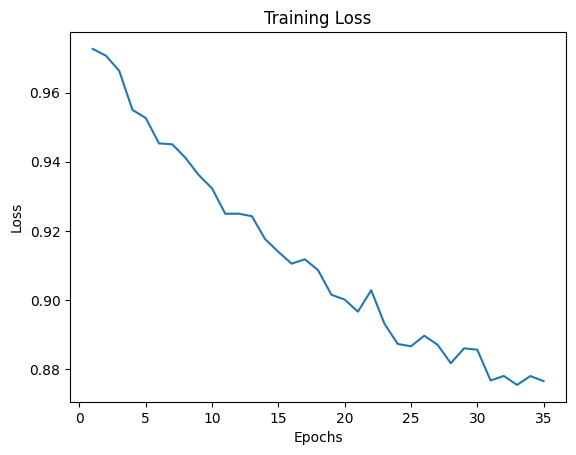

In [36]:
epoch_list = list(range(1, len(losses) + 1))
plt.plot(epoch_list, losses)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [37]:
def accuracy(correct, total):
  return correct/total * 100

In [38]:
def test_loop(test_dataloader, model):
  model.eval() # Put the model in evaluation mode
  correct = 0
  total = 0

  with torch.no_grad():
    for image, label in tqdm(test_dataloader, desc="Testing Model"):
      pred = model(image)

      correct += (pred.argmax(1) == label).type(torch.float).sum().item()
      total += len(label)

    print(f'Accuracy: {accuracy(correct, total)}')

In [39]:
test_loop(test_dataloader, model)

Testing Model: 100%|██████████| 313/313 [00:02<00:00, 114.29it/s]

Accuracy: 61.019999999999996


#Visualize Testing

torch.Size([3, 32, 32])


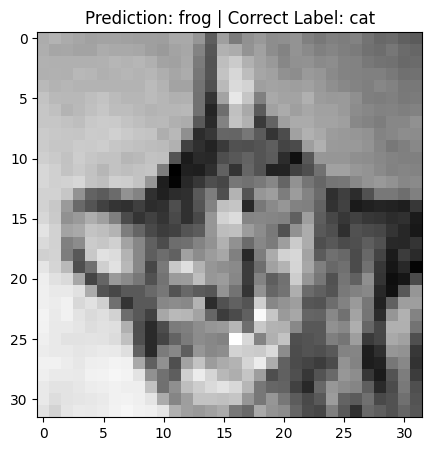

In [ ]:
rand_idx = torch.randint(0, len(test_data), (1,)).item()
image, label = test_data[rand_idx]

print(image.shape)
with torch.no_grad():
  prediction = model(image.unsqueeze(0))

# Get the predicted class index
pred_idx = prediction[0].argmax().item()  # For first image in batch

plt.figure(figsize=(5,5))
plt.title(f'Prediction: {test_data.classes[pred_idx]} | Correct Label: {test_data.classes[label]}')
plt.imshow(image[0].squeeze(), cmap='gray')  # Show first image in batch
plt.show()

#Data Augmentation & Loading Open Source Dataset
Data Augmentation is a technique used to artificially increase the size of your training dataset by creating modified versions of your existing data. Think of it like taking a photo and creating several variations of it - tilting it slightly, making it brighter or darker, flipping it horizontally, or zooming in a bit.

In this case our model is very small, only two Conv Layers and 2 linear layers
But but what if this was our model was 50 layers? Thats a pretty big model. The amount of data you would need to train that would be much larger than 50,000 images, a good amount would maybe be 100,000-1,000,000 depending on the complexity of the model

###Load Data


In [ ]:
train_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
    )

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_data.data.transpose(0, 3, 1, 2).shape

(50000, 3, 32, 32)

In [ ]:
import albumentations as A
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
def HorizontalFlip():
    return A.Compose([
        A.HorizontalFlip(p=1.0),
    ])

HorizontalFlip = HorizontalFlip()

Shape of original image is: torch.Size([32, 32, 3])


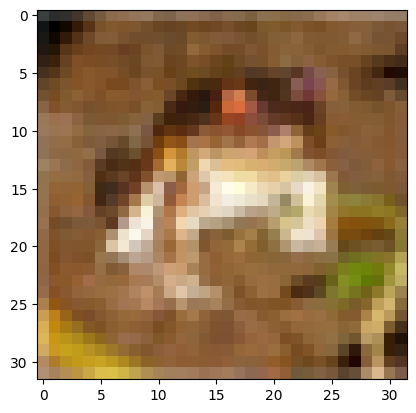

Shape of augmented image is: (32, 32, 3)


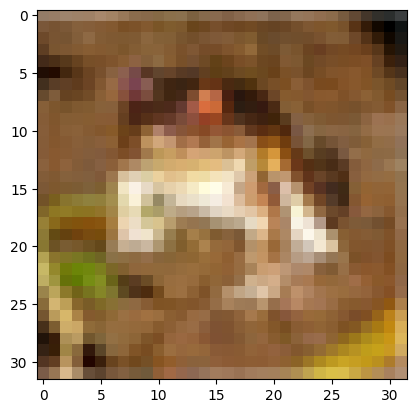

In [ ]:
for original_image, label in train_data:

  original_image = original_image.permute(1, 2, 0)
  print(f'Shape of original image is: {original_image.shape}')
  plt.imshow(original_image)
  plt.show()

  augmented_image = HorizontalFlip(image=np.array(original_image))['image']
  print(f'Shape of augmented image is: {augmented_image.shape}')
  plt.imshow(augmented_image)
  plt.show()

  break

In [ ]:
augmented_data = {
    'images': [],
    'labels': []
}

for original_image, label in tqdm(train_data):
    original_np = original_image.numpy()

    # Apply horizontal flip
    augmented_image = HorizontalFlip(image=original_np)['image']
    augmented_image = augmented_image.transpose(0,1,2)

    augmented_data['images'].append(augmented_image)
    augmented_data['labels'].append(label)

# Convert to numpy arrays
augmented_images = np.array(augmented_data['images'])  # Should be (N, 3, 32, 32)
augmented_labels = np.array(augmented_data['labels'])

# Now they should have matching dimensions for concatenation
print("Shapes before concatenation:")
print(f"Original data shape: {train_data.data.transpose(0, 3, 1, 2).data.shape}")
print(f"Augmented data shape: {augmented_images.shape}")

train_images = np.concatenate((train_data.data.transpose(0, 3, 1, 2).data, augmented_images), axis=0)
train_labels = np.concatenate((np.array(train_data.targets), augmented_labels), axis=0)

100%|██████████| 50000/50000 [00:15<00:00, 3145.74it/s]


Shapes before concatenation:
Original data shape: (50000, 3, 32, 32)
Augmented data shape: (50000, 3, 32, 32)


In [ ]:
len(train_images)

100000

In [ ]:
train_data = TensorDataset(torch.tensor(train_images), torch.tensor(train_labels))
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)

In [ ]:
for image, label in train_dataloader:
  print(f'Shape of the images: {image.shape}')
  print(f'Shape of the labels: {label.shape}')
  break

Shape of the images: torch.Size([32, 3, 32, 32])
Shape of the labels: torch.Size([32])


In [ ]:
losses = train_loop(train_dataloader, model, loss_fn, optimizer, epochs=1) # Lets take a few minute break while it trains and we will come back

Training Model:  28%|██▊       | 877/3125 [00:30<01:14, 30.18it/s]

# Viola just like that, you have 50,000 more images to train your model on


# Saliency Maps